In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pickle for saving
import pickle as plk

### scikitlearn
import sklearn as sk
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression

In [2]:
def create_our_columns(dataframe):
    grouped = dataframe.groupby('ident')
    masa_total = grouped.sum()['emepla(i)/emet']
    eficiencia = masa_total/(grouped['emed'].first())
    n_planetas = grouped.size()
    
    n_planetas.name = 'nplanets'
    masa_total.name = 'tmass'
    eficiencia.name = 'eff'
    
    new = dataframe.join(n_planetas, on='ident')
    new = new.join(masa_total, on='ident')
    new = new.join(eficiencia, on='ident')
    
    return new

def scalate(splitted_data):
    X_train, X_test, Y_train, Y_test = splitted_data
    if len(Y_train.shape) == 1:
        Y_train = Y_train.values.reshape((-1, 1))
        Y_test = Y_test.values.reshape((-1, 1))
        
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_ = scaler.transform(X_train)
    X_test_ = scaler.transform(X_test)
    
    scaler = preprocessing.StandardScaler().fit(Y_train)
    Y_train_ = scaler.transform(Y_train)
    Y_test_ = scaler.transform(Y_test)
    
    return X_train_, X_test_, Y_train_, Y_test_

# Load data

In [3]:
low = pd.read_csv('lowp_finalresults.csv')
high = pd.read_csv('highp_finalresults.csv')

In [4]:
low_complete = create_our_columns(low)
high_complete = create_our_columns(high)

# LASSO studies

A $\beta$ value different from zero indicates that the parameter is important in the model, the most influent ones are found at large values of $\lambda$. We found that values depend a lot on the training sample, thus we decided to make a total of 100 tests, we present the average result.

In [5]:
def lasso_test(data, n_keys, lambdas):
    N = len(lambdas)
    
    X_train, X_test, Y_train, Y_test = data
    
    coefs_norm = np.zeros((N, n_keys + 1))
    scores_norm = np.zeros(N)

    for i in range(N):
        clf = Lasso(alpha = lambdas[i])
        clf.fit(X_train, Y_train)
        coefs_norm[i, 0] = clf.intercept_
        coefs_norm[i, 1:] = clf.coef_
        scores_norm[i] = clf.score(X_test, Y_test)
        
    return coefs_norm, scores_norm
    
def multiple_lasso_testing(dataframe, wanted_index = 0, number_of_test = 1):
    grouped = dataframe.groupby('ident')
    data = grouped.mean()
    keys = list(data.keys())
    wanted = ['nplanets', 'tmass', 'eff']
    to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

    for key in to_remove:
        keys.remove(key)
        
    X_data = data[keys]
    Y_data = data[wanted[wanted_index]]
    n_keys = len(keys)
    n_lambdas = 100
    lambdas = np.logspace(-3, -1, n_lambdas)
    set_coefs = np.zeros((number_of_test, n_lambdas, n_keys + 1))
    set_scores = np.zeros((number_of_test, n_lambdas))
    for i in range(number_of_test):
        splitted = train_test_split(X_data, Y_data)
        coefs_norm, scores_norm = lasso_test(scalate(splitted), n_keys, lambdas)
        set_coefs[i] = coefs_norm
        set_scores[i] = scores_norm
        
    return keys, lambdas, set_coefs, set_scores

def plot(resulting_data):
    keys, lambdas, coeffs, scores = resulting_data
    mean = coeffs.mean(axis=0)
    std = coeffs.std(axis=0)
    fig, ax = plt.subplots()
    for i in range(std.shape[1]-1):
        if i < 10:
            line = '-'
        else:
            line = '--'
        keys[i]
        ax.loglog(lambdas, abs(mean[:, i+1]), line,\
                     label = r"$\beta_{%d}$ '%s'"%(i+1, keys[i]))
    ax.set_ylabel('Coeficientes')
    ax.set_xlabel(r'$\lambda$ value')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    return fig, ax

## Planets number
### lowp_finalresults

/home/juan/.anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


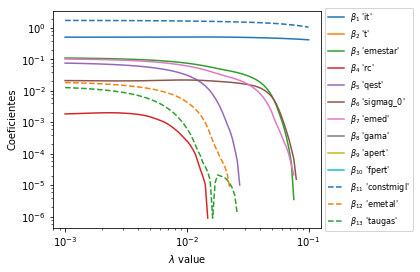

In [6]:
fig, ax = plot(multiple_lasso_testing(low_complete, 0, 100))
fig

### highp_finalresults

/home/juan/.anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


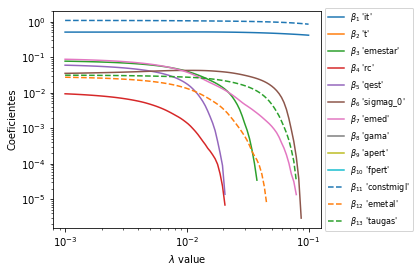

In [7]:
fig, ax = plot(multiple_lasso_testing(high_complete, 0, 100))
fig

## Total mass
### lowp_finalresults

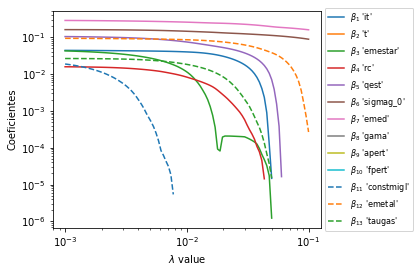

In [8]:
fig, ax = plot(multiple_lasso_testing(low_complete, 1, 100))
fig

### highp_finalresults

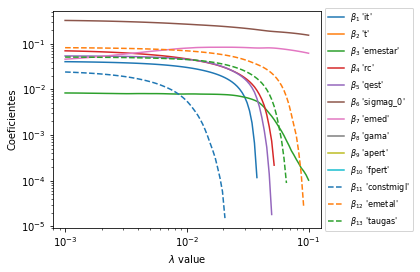

In [9]:
fig, ax = plot(multiple_lasso_testing(high_complete, 1, 100))
fig

## Efficiency
### lowp_finalresults

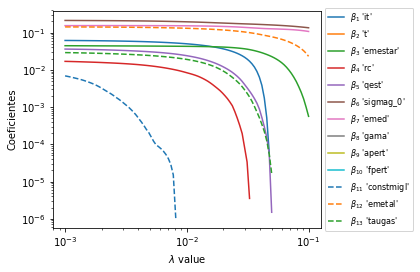

In [10]:
fig, ax = plot(multiple_lasso_testing(low_complete, 2, 100))
fig

### highp_finalresults

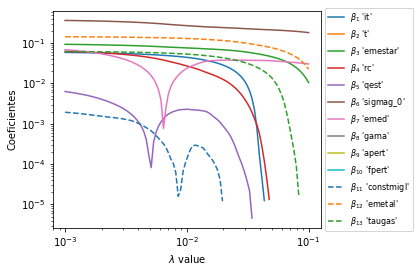

In [11]:
fig, ax = plot(multiple_lasso_testing(high_complete, 2, 100))
fig

The wanted index indicates the target variable, which is used for an F-test, in which a p-value smaller than 0.05 indicates that the paramete is important

# Prediction
## Eficiencia
### lowp_finalresults

In [12]:
wanted_index = 2
low_complete
grouped = low_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]

F, pval = f_regression(X_data, Y_data)
print(pval)
print(pval < 0.05)

[  1.05367975e-02              nan   5.12813798e-27   2.15867021e-02
   2.30100967e-07   4.66482455e-71   7.54046787e-69              nan
              nan              nan   1.45355771e-04   1.29402028e-08
   4.39959631e-02]
[ True False  True  True  True  True  True False False False  True  True
  True]


/home/juan/.anaconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/home/juan/.anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/juan/.anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/juan/.anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/juan/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


The results obtained by the F stadistic show that most of the parameters are important, which agrees with LASSO results.

A polynomial model is used to better adjust the data, while only the interactions are taken into account to avoid overfitting.

A perfect score of 1 indicates a perfect fit, although it can be infinitely bad, taking negative values

In [13]:
model = Pipeline([('poly', PolynomialFeatures(degree=3,interaction_only=True)),('linear', LinearRegression(normalize=False,n_jobs=-1))])
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
sk.metrics.r2_score(Y_test, y_pred)

0.08395430705130702

In [14]:
y_pred = model.predict(X_test)
print(sk.metrics.r2_score(Y_test, y_pred))

0.0839543070513


A very small part of the variance is explained 36%, and only a small portion of the the data are classified correctly

Most of the values of the prediction are between 11 and 13, which indicates a prediction that is close to the average, accounting for the small amount of explained variance

### highp_finalresults

In [15]:
wanted_index = 2
low_complete
grouped = high_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]

F, pval = f_regression(X_data, Y_data)
print('p value', pval)
print('important parameters', pval < 0.05)

model = Pipeline([('poly', PolynomialFeatures(degree=3,interaction_only=True)),('linear', LinearRegression(normalize=False,n_jobs=-1))])
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
sk.metrics.r2_score(Y_test, y_pred)

y_pred = model.predict(X_test)
print('r2 score', sk.metrics.r2_score(Y_test, y_pred))

p value [  6.41496320e-03              nan   5.95921251e-28   1.05346014e-02
   4.48983431e-07   4.88862007e-63   2.32395592e-52              nan
              nan              nan   2.59395107e-02   4.56098244e-09
   1.35646431e-04]
important parameters [ True False  True  True  True  True  True False False False  True  True
  True]
r2 score 0.179272703085


/home/juan/.anaconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/home/juan/.anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/juan/.anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/juan/.anaconda3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/juan/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


Use this section to save the best fits as they are found

In [16]:
#plk.dump(model, open('best2.p', 'wb'))

## Planets
### lowp_finalresults

We thought that the planet regression problem, could also be treated with a classification scheme, since the planets are discrete values, and their rank is finite. Nevertheless the classification approach can not predict values outside the training rank.

Kneighbors was used to classify the systems according to the number of planets, without much success

In [17]:
multi = KNeighborsClassifier(n_neighbors=2000)

wanted_index = 0
low_complete
grouped = low_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)

multi.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2000, p=2,
           weights='uniform')

An attempt was made to cast the variable as type int, given the fact that the number of planets is descrete. Accuracy and explained variance scores are given

In [19]:
y_pred = multi.predict(X_test)
y_preds = np.rint(y_pred).astype(int)
print(accuracy_score(Y_test, y_preds))
print(sk.metrics.r2_score(Y_test, y_preds))

0.127970749543
-0.0354027772146


In [20]:
y_pred = multi.predict(X_test)
accuracy_score(Y_test, y_pred)

0.12797074954296161

### highp_finalresults

In [21]:
multi = KNeighborsClassifier(n_neighbors=2000)

wanted_index = 0
low_complete
grouped = high_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)

multi.fit(X_train,Y_train)


y_pred = multi.predict(X_test)
y_preds = np.rint(y_pred).astype(int)
print('accuracy', accuracy_score(Y_test, y_preds))
print('r2 score', sk.metrics.r2_score(Y_test, y_preds))

accuracy 0.120938628159
r2 score -0.0289162546122


## planet mass
### lowp_finalresults

A polynomial model was applied to the planet mass, using a linear regression

In [22]:
wanted_index = 1
low_complete
grouped = low_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]

#F, pval = f_regression(X_data, Y_data)

In [23]:
model = Pipeline([('poly', PolynomialFeatures(degree=3,interaction_only=True)),('linear', KNeighborsRegressor(n_jobs=-1))])
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
sk.metrics.r2_score(Y_test, y_pred)

-0.71339691603578692

### highp_finalresults

In [24]:
wanted_index = 1
low_complete
grouped = high_complete.groupby('ident')
data = grouped.mean()
keys = list(data.keys())
wanted = ['nplanets', 'tmass', 'eff']
to_remove = ['a(i)', 'emegas(i)', 'emepla(i)/emet'] + wanted

for key in to_remove:
    keys.remove(key)
        
X_data = data[keys]
Y_data = data[wanted[wanted_index]]

#F, pval = f_regression(X_data, Y_data)

In [25]:
model = Pipeline([('poly', PolynomialFeatures(degree=3,interaction_only=True)),('linear', KNeighborsRegressor(n_jobs=-1))])
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
sk.metrics.r2_score(Y_test, y_pred)

-0.08608602403768284

# Disclaimer
The best fits for each parameter are saved in the files with .p extension. best.p is the model for the number of planets, best1.p is the model for the planet mass, and best2.p is the model for the efficiency. To load the models use:

In [ ]:
#model = plk.load(open('best.p', 'rb'))